In [249]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['animation.html'] = 'html5'
import numpy as np
import scipy as sp
import scipy.integrate
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from spectral import *
np.set_printoptions(linewidth=120)

In [259]:
L, R = 100, 5
mesh = Legendre(101, endpoints=(-L, L))

rho = 1.06; E = 3.7; nu = 0.34; l = -18.9; m = -13.3; n = -10.0 # PS
c = np.sqrt(E/rho)#*coord_scale/time_scale

# nonlinearity and dispersion coefficients
beta1 = (3*E + 2*l*(1 - 2*nu)**3 + 4*m*(1 + nu)**2*(1 - 2*nu) + 6*n*nu**2)
beta2 = (3*E + 2*l*(1 - 2*nu)**3 + 4*m*(1 + nu)**2*(1 - 2*nu) + 6*n*nu**2)
beta3 = (3*E + 2*l*(1 - 2*nu)**3 + 4*m*(1 + nu)**2*(1 - 2*nu) + 6*n*nu**2)
alph1 = (1 + nu)/4
alph2 = -(1 + nu + nu**2)/2
alph3 = (1 + nu)/4

alph1m = R**2*alph1/c**2
alph2m = R**2*alph2
alph3m = R**2*alph3*c**2
beta1m = beta1/2/rho
beta2m = beta2/E/rho
beta3m = beta3/2/E**2/rho

In [260]:
def compress(u, v, w, q):
    return np.stack((u.func, v.func, w.func, q.func)).ravel()

def decompress(y):
    func_u, func_v, func_w, func_q = y.reshape(4, 1, *mesh.shape)
    u = TensorField(mesh, func_u)
    v = TensorField(mesh, func_v)
    w = TensorField(mesh, func_w)
    q = TensorField(mesh, func_q)
    return u, v, w, q

def derivative(t, y):
    u, v, w, q = decompress(y)
    du_dt = v
    dv_dt = w
    dw_dt = q
    u2 = u@u
    dq_dt = (4*c*(q.diff() + c**2*v.diff().diff().diff()) 
             + (2*c*v.diff() - w - (alph2m + 6*c*alph1m)*w.diff().diff()
                - (alph3m + c**2*alph2m + c**4*alph1m)*u.diff().diff().diff().diff()
                + 2*alph2m*c*v.diff().diff().diff() + beta1m*u2.diff().diff())/alph1m)
    return compress(du_dt, dv_dt, dw_dt, dq_dt)

In [261]:
def soliton(x):
    A = -0.1
    D = R * np.sqrt(-4*(alph1*(A*beta1 + 3*E)**2 
                    + 3*E*(A*beta1 + 3*E)*alph2 
                    + 9*E**2*alph3)/(3*A*beta1*E))
    V = np.sqrt(c**2 + A*beta1/3/rho) - c
    arg = x/D
    u = A*np.cosh(arg)**(-2)
    v = 2*V/D*np.tanh(arg)*u
    w = 2*A*V**2/D**2*(-2 + np.cosh(2*arg))*np.cosh(arg)**(-4)
    q = 4*A*V**3/D**3*(-5 + np.cosh(2*arg))*np.cosh(arg)**(-4)*np.tanh(arg)
    return [u, v, w, q]

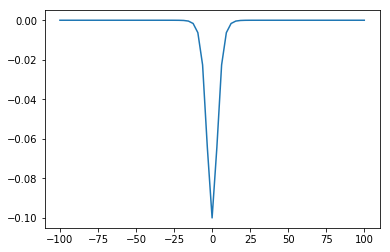

In [262]:
x = np.array(mesh.grid())[0, :]
plt.plot(x, soliton(x)[0])

In [263]:
t0 = 0
t_max = 30.0
dt = 0.5
T = np.arange(t0, t_max + dt/2, dt)

u0 = TensorField(mesh, soliton(mesh.grid())[0])
v0 = TensorField(mesh, soliton(mesh.grid())[1])
w0 = TensorField(mesh, soliton(mesh.grid())[2])
q0 = TensorField(mesh, soliton(mesh.grid())[3])

U = TensorField(mesh, np.zeros((len(T), 1) + mesh.shape))
V = TensorField(mesh, np.zeros((len(T), 1) + mesh.shape))
W = TensorField(mesh, np.zeros((len(T), 1) + mesh.shape))
Q = TensorField(mesh, np.zeros((len(T), 1) + mesh.shape))

U[0], V[0], W[0], Q[0] = u0, v0, w0, q0

In [264]:
r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
#r.set_initial_value(compress(u0, v0, w0, q0), t=t0)
ok = True
for k, t in enumerate(Progress(T[:-1])):
    r.set_initial_value(compress(U[k], V[k], W[k], Q[k]), t=t0)
    r.integrate(dt)
    U[k+1], V[k+1], W[k+1], Q[k+1] = decompress(r.y)
    
    #if len(r.t) > 2 and ok:
    #    print('Warning: more than one iteration was done (',len(r.t) - 1,'). i = ', i)
    #    ok = False

HTML(value='')

/home/feodor/anaconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1095: UserWarning: dop853: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))


KeyboardInterrupt: 

In [267]:
fig, ax = plt.subplots()
plt.xlim(-L, L)
plt.ylim(-0.05, 0.12)
plt.grid()
line, = ax.plot([], [])
time_template = 'time = %.1f'
time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)
plt.xlabel(r'$x$')
plt.ylabel(r'$-u(x)$')
plt.close()

def animate(k):
    x = np.linspace(-L, L, 301)
    line.set_data(x, -U[k](x)[:, 0])
    time_text.set_text(time_template % T[k])
    return line, time_text

animation.FuncAnimation(fig, animate, frames=len(T), interval=50, blit=True)